Enter image filename (with extension): pic3.png


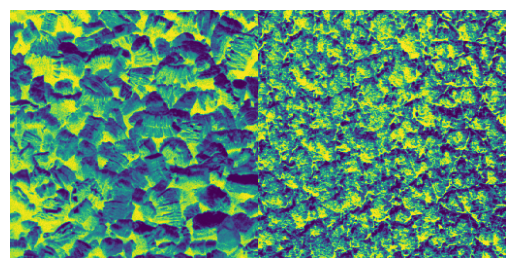

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Ask the user for the image filename
filename = input("Enter image filename (with extension): ")  # e.g. pic1.jpg

# 2️⃣ Open the image using PIL
img = Image.open(filename)

# 3️⃣ Convert to NumPy array
img_array = np.array(img)


plt.imshow(img_array)
plt.axis("off")
plt.show()


Equalized image saved as: pic3_equalized.jpg


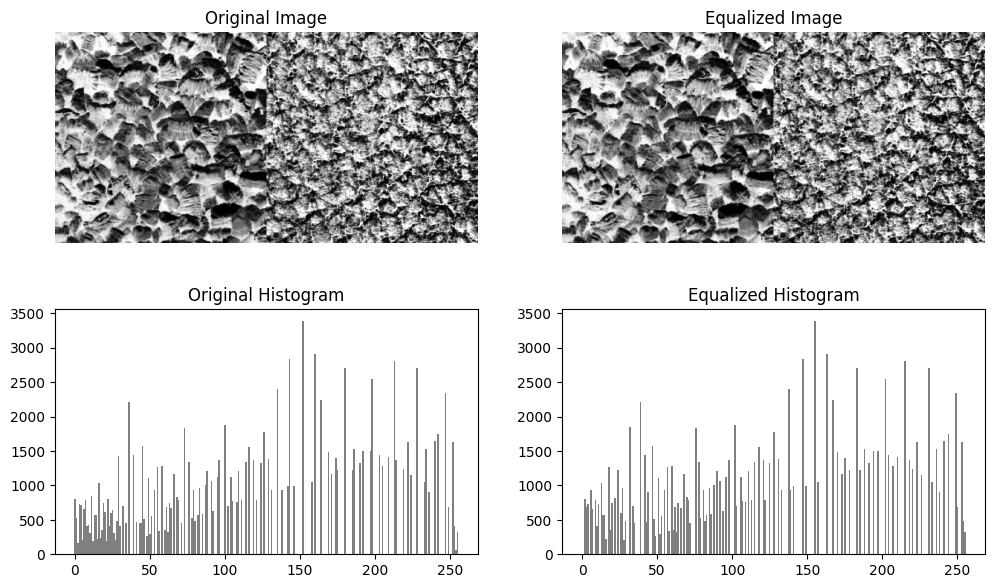

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Compute histogram (PDF)
hist = np.zeros(256)
for pixel in img_array.flatten():
    hist[pixel] += 1
pdf = hist / hist.sum()

# CDF and mapping: y = 255 * Σ p(x)
cdf = np.cumsum(pdf)
equalization_map = np.round(255 * cdf).astype(np.uint8)
equalized_array = equalization_map[img_array]

# Save equalized image
equalized_img = Image.fromarray(equalized_array)
output_filename = filename.split('.')[0] + "_equalized.jpg"
equalized_img.save(output_filename)

# Compute equalized histogram for plotting
hist_eq = np.zeros(256)
for pixel in equalized_array.flatten():
    hist_eq[pixel] += 1

# Plot 2×2 figure like your sample
fig, axes = plt.subplots(2, 2, figsize=(12, 7))

# Top row: original and equalized images
axes[0,0].imshow(img_array, cmap='gray')
axes[0,0].set_title("Original Image")
axes[0,0].axis("off")

axes[0,1].imshow(equalized_array, cmap='gray')
axes[0,1].set_title("Equalized Image")
axes[0,1].axis("off")

# Bottom row: histograms
axes[1,0].bar(np.arange(256), hist, color='gray', width=1)
axes[1,0].set_title("Original Histogram")

axes[1,1].bar(np.arange(256), hist_eq, color='gray', width=1)
axes[1,1].set_title("Equalized Histogram")


print("Equalized image saved as:", output_filename)


Enter kernel size (odd integer, e.g., 3, 5, 7): 5


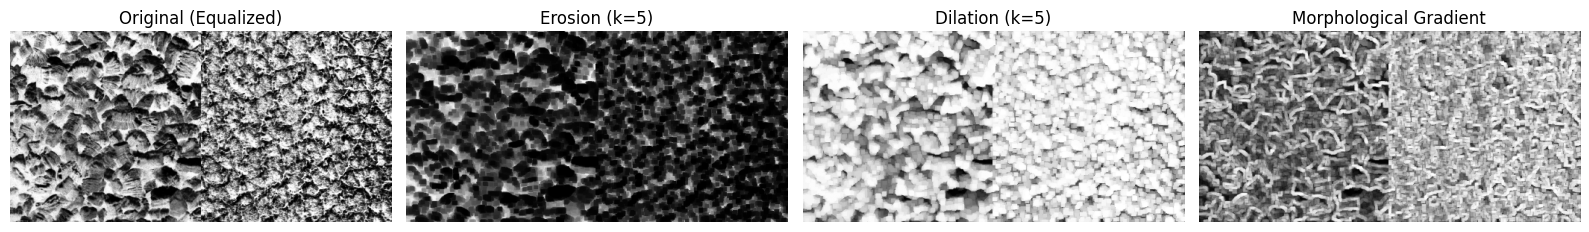

Saved results as:
 pic3_erosion.jpg
 pic3_dilation.jpg
 pic3_grad.jpg


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# -------------------- Morphological Functions --------------------

def erosion_scratch(img, kernel_size):
    """
    Perform morphological erosion without using any library.
    img: 2D numpy array (grayscale)
    kernel_size: odd integer (e.g., 3, 5, 7)
    """
    pad = kernel_size // 2
    padded_img = np.pad(img, pad, mode='edge')  # replicate borders
    eroded = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+kernel_size, j:j+kernel_size]
            eroded[i, j] = np.min(window)  # erosion → minimum in neighborhood
    return eroded


def dilation_scratch(img, kernel_size):
    """
    Perform morphological dilation without using any library.
    img: 2D numpy array (grayscale)
    kernel_size: odd integer (e.g., 3, 5, 7)
    """
    pad = kernel_size // 2
    padded_img = np.pad(img, pad, mode='edge')
    dilated = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+kernel_size, j:j+kernel_size]
            dilated[i, j] = np.max(window)  # dilation → maximum in neighborhood
    return dilated


# -------------------- User Input and Processing --------------------

# Ask user for kernel size
kernel_size = int(input("Enter kernel size (odd integer, e.g., 3, 5, 7): "))

# Load the equalized image (ensure it exists)

img = Image.open(filename).convert("L")
img_array = np.array(img)

# Perform erosion, dilation, and morphological gradient
eroded_img = erosion_scratch(img_array, kernel_size)
dilated_img = dilation_scratch(img_array, kernel_size)
grad_img = dilated_img - eroded_img

# Save all outputs
base = filename.split('.')[0]
Image.fromarray(eroded_img).save(base + "_erosion.jpg")
Image.fromarray(dilated_img).save(base + "_dilation.jpg")
Image.fromarray(grad_img).save(base + "_grad.jpg")

# -------------------- Display Results --------------------

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(img_array, cmap='gray')
axes[0].set_title("Original (Equalized)")
axes[0].axis("off")

axes[1].imshow(eroded_img, cmap='gray')
axes[1].set_title(f"Erosion (k={kernel_size})")
axes[1].axis("off")

axes[2].imshow(dilated_img, cmap='gray')
axes[2].set_title(f"Dilation (k={kernel_size})")
axes[2].axis("off")

axes[3].imshow(grad_img, cmap='gray')
axes[3].set_title("Morphological Gradient")
axes[3].axis("off")

plt.tight_layout()
plt.show()

print(f"Saved results as:\n {base}_erosion.jpg\n {base}_dilation.jpg\n {base}_grad.jpg")



Parameters
Closing sizes (e.g., 3,5,7,9): 9,11,13,15
Opening size (> separation): 60
Threshold factor [0.3]: 0.3


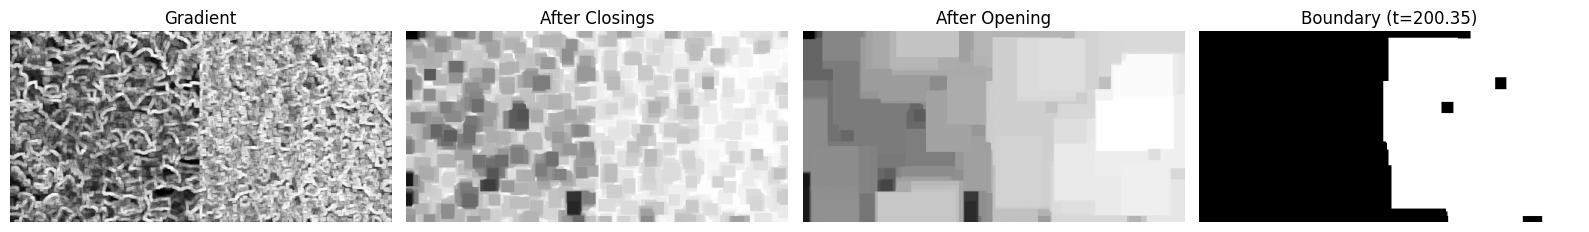

Saved: pic3_after_closings.jpg, pic3_after_opening.jpg, pic3_texture_boundary.jpg


In [4]:
# ===== Textural Segmentation (Simple) =====
# Needs: erosion_scratch(img, k), dilation_scratch(img, k)

def open_s(img, k):
    # Opening = erosion then dilation
    return dilation_scratch(erosion_scratch(img, k), k)

def close_s(img, k):
    # Closing = dilation then erosion
    return erosion_scratch(dilation_scratch(img, k), k)

def make_odd(k):
    # Ensure kernel size is odd
    return k if k % 2 == 1 else k + 1

def texture_segment(grad_img, close_sizes, open_size, thr_factor=0.3):
    """
    Three steps:
      1) Successive CLOSINGS with sizes in close_sizes  -> remove small blobs
      2) One OPENING with size open_size                -> remove dark gaps
      3) THRESHOLD (mean + thr_factor*std)              -> binary boundary
    Returns: (img_after_closings, img_after_opening, boundary_mask)
    """
    # 0) Clean sizes
    close_sizes = [make_odd(k) for k in close_sizes]
    open_size   = make_odd(open_size)

    # 1) Successive closings
    img1 = grad_img.copy()
    for k in close_sizes:
        img1 = close_s(img1, k)

    # 2) Single opening (SE > separation between large blobs)
    img2 = open_s(img1, open_size)

    # 3) Simple threshold
    t = img2.mean() + thr_factor * img2.std()
    boundary = (img2 > t).astype(np.uint8) * 255

    return img1, img2, boundary, t

# --------- Minimal runner ---------
base = filename.split('.')[0]
grad = np.array(Image.open(base + "_grad.jpg").convert("L"))

print("\nParameters")
close_sizes = [int(x) for x in input("Closing sizes (e.g., 3,5,7,9): ").split(",")]
open_size   = int(input("Opening size (> separation): "))
tf = input("Threshold factor [0.3]: ").strip()
tf = float(tf) if tf else 0.3

img1, img2, boundary, thr = texture_segment(grad, close_sizes, open_size, tf)

Image.fromarray(img1).save(base + "_after_closings.jpg")
Image.fromarray(img2).save(base + "_after_opening.jpg")
Image.fromarray(boundary).save(base + "_texture_boundary.jpg")

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(grad, cmap="gray");     ax[0].set_title("Gradient");        ax[0].axis("off")
ax[1].imshow(img1, cmap="gray");     ax[1].set_title("After Closings");  ax[1].axis("off")
ax[2].imshow(img2, cmap="gray");     ax[2].set_title("After Opening");   ax[2].axis("off")
ax[3].imshow(boundary, cmap="gray"); ax[3].set_title(f"Boundary (t={thr:.2f})"); ax[3].axis("off")
plt.tight_layout(); plt.show()

print(f"Saved: {base}_after_closings.jpg, {base}_after_opening.jpg, {base}_texture_boundary.jpg")


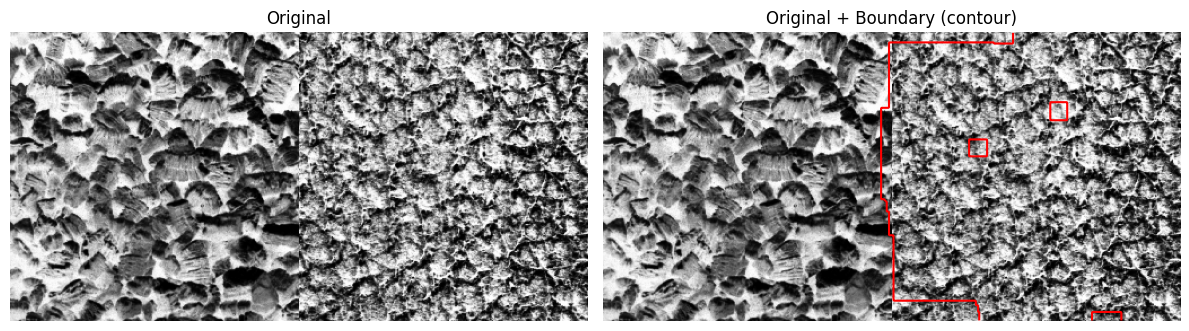

In [5]:
# Inputs:
# - original grayscale image array: orig = np.array(Image.open(filename).convert("L"))
# - boundary: binary mask in {0,255} from your texture_segment()

orig = np.array(Image.open(filename).convert("L"))
mask = boundary > 127  # boolean

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(orig, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")

ax[1].imshow(orig, cmap="gray"); ax[1].axis("off")
# draw red contour
ax[1].contour(mask, colors="red", linewidths=1.5)
ax[1].set_title("Original + Boundary (contour)")

plt.tight_layout(); plt.show()
